<a href="https://colab.research.google.com/github/AmandinChyba/Project1-Fields-2022/blob/main/non_convex/nonconvex_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import jax
from jax import lax
import jax.random as jrandom
import jax.numpy as jnp
import numpy as np
import time
import matplotlib.pyplot as plt
from functools import partial

# Utility Functions

In [146]:
'''
signed distance function of the domain
'''
@jax.jit
def signDistance(p): # [cuts, samples, dimensions]
  R = 2
  r = 1
  temp = jnp.sum(jnp.power(p,2), axis=2) + jnp.power(R,2) - jnp.power(r,2)
  final = jnp.power(temp,2) - 4 * jnp.power(R,2) * (jnp.power(p[:,:,0], 2) + jnp.power(p[:,:,1], 2))
  return final
  #return jnp.linalg.norm(p,ord=2,axis=2,keepdims=False) - 1 # unit sphere

In [147]:
'''
Dirchlet boundary condition
'''
@jax.jit
def boundaryCond(p, k):
  pointCharge = jnp.array([0,0,0])
  pointCharge = jnp.tile(pointCharge, (jnp.size(p,0), 1)) # [samples, dimensions]
  pDiff = jnp.linalg.norm(p - pointCharge, ord=2, axis=1, keepdims=False)
  return jnp.exp(-k * pDiff) / (4 * jnp.pi * pDiff)

In [148]:
'''
the true solution
'''
@jax.jit
def trueSoln(p, k):
  pointCharge = jnp.array(jnp.size(p,0)*[0,0,0]).reshape(jnp.size(p,0),jnp.size(p,1)) # [solutions, dimensions]
  pDiff = jnp.linalg.norm(p - pointCharge, ord=2, axis=1)
  return jnp.exp(-k * pDiff) / (4 * jnp.pi * pDiff)

# Multi Root Finding

In [149]:
@jax.jit
def bisection(p0, p1, rootSteps, dir):
  current = jnp.zeros((1, jnp.size(p0, 1)))

  def bisectionStep(i, current):
    next = current + jnp.power(0.5, i+1)
    dist1 = signDistance(p0 + dir * next[:,:,jnp.newaxis] * (p1 - p0))
    dist2 = signDistance(p0 + dir * current[:,:,jnp.newaxis] * (p1 - p0))
    return jnp.where(dist1 * dist2 > 0, next, current)

  current = lax.fori_loop(0, rootSteps, bisectionStep, current)

  return p0 + dir * current[:,:,jnp.newaxis] * (p1 - p0)

In [150]:
@partial(jax.jit, static_argnames=['uni_cuts', 'quad_cuts'])
def createGrid(p0, p1, uni_cuts, quad_cuts):
  lb = jnp.zeros(len(p0))
  ub = jnp.ones(len(p1))
  t = jnp.linspace(lb, ub, uni_cuts, axis=0)
  return t
  '''
  v = jnp.abs(signDistance(p0 + t[:,:,jnp.newaxis] * (p1 - p0)))

  # quad_cuts should be greater than or equal to uni_cuts? not true?
  
  # smart variation
  uni_space = (ub - lb) / (uni_cuts - 1)
  threshold = jnp.linalg.norm(p1 - p0, ord=2, axis=1) / (2 * (uni_cuts - 1))
  n_close = jnp.count_nonzero(v < threshold, axis=0)
  
  spacing_amount = ((quad_cuts - uni_cuts) // n_close).astype(int) + 1
  spacing_value = uni_space / (spacing_amount)

  h = jnp.where(v < threshold, spacing_amount, 1)
  lol = jnp.where(v < threshold, spacing_value, uni_space)

  extra = quad_cuts % (n_close * spacing_amount + uni_cuts - n_close)
  h = h.at[-1].add(extra)

  lol2 = jnp.ravel(lol, order='F')
  h2 = jnp.ravel(h, order='F')
  xd = jnp.repeat(lol2, h2, total_repeat_length=quad_cuts * len(lb))
  xd = jnp.reshape(xd, (quad_cuts, len(lb)), order='F')
  xd = jnp.cumsum(xd, axis=0)
  xd -= uni_space / 2
  print("finished grid building")

  return xd
  '''
  

In [151]:
@partial(jax.jit, static_argnames=['ray'])
def rootIsolate(key, p0, p1, grid, ray=False):
  # find the roots
  v = signDistance(p0 + grid[:,:,jnp.newaxis] * (p1 - p0))
  v = jnp.where(v > 0, 1, -1)

  # get rid of the first half of the line
  if (ray):
    # < : underestimate
    # > : underestimate (but less?)
    v = jnp.where(grid < 0.5, 10, v)

  # find the roots
  roots = v[:-1] + v[1:]

  # get rid of the root closest to 0.5
  if (not ray):
    # BUG: HAS TO DELETE SOMETHING EVEN IF THERES NOTHING TO DELETE. fixed?
    n_zeros = jnp.count_nonzero(roots == 0, axis=0)
    thing_tile = jnp.abs(grid[:-1]-0.5) + 1
    n_zeros_tile = jnp.tile(n_zeros, (jnp.size(roots, 0), 1))
    closetomid = jnp.min((jnp.abs(roots) + 1) * thing_tile, axis=0)
    roots = jnp.where(jnp.logical_and((jnp.abs(roots) + 1) * thing_tile == closetomid, n_zeros_tile != 0), 100, roots)

  # check how many roots
  n_zeros = jnp.count_nonzero(roots == 0, axis=0)
  #print("average amount of roots on the lines:", jnp.mean(n_zeros))

  need_n_zeros = n_zeros
  #print("WARNING! this many tangent lines with no roots:", jnp.count_nonzero(n_zeros == 0))
  
  # when we find no roots, pick the previous one
  #n_zeros_tile = jnp.tile(n_zeros, (jnp.size(roots, 0), 1))
  #roots = jnp.where(jnp.logical_and(n_zeros_tile == 0, jnp.abs(roots) > 50), 0, roots)
  #n_zeros = jnp.count_nonzero(roots == 0, axis=0)

  # BUG: if there are still no roots, pick the middle of the line
  # THIS REQUIRES THE GRID TO CONTAIN 0.5 
  n_zeros_tile = jnp.tile(n_zeros, (jnp.size(roots, 0), 1))
  roots = jnp.where(jnp.logical_and(n_zeros_tile == 0, grid[:-1] == 0.5), 0, roots)
  n_zeros = jnp.count_nonzero(roots == 0, axis=0)

  #print("this many tangent lines with no roots after the fix:", jnp.count_nonzero(n_zeros == 0))

  # randomly pick a root
  minvals = jnp.zeros(jnp.size(grid, 1))
  random_indices = jrandom.randint(key, (1,jnp.size(grid, 1)), minval=minvals, maxval=n_zeros)

  # can speed this up by using a single for loop instead of: argsort + take_along_axis + custom_put_along_axis ?
  roots = jnp.where(roots == 0, 0, 1)
  all_root_indices = jnp.argsort(roots, axis=0)
  root_indices = jnp.take_along_axis(all_root_indices, random_indices, axis=0)

  lb = jnp.take_along_axis(grid, root_indices, axis=0)
  ub = jnp.take_along_axis(grid, root_indices+1, axis=0)
  
  # return the roots interval
  return lb, ub, n_zeros, need_n_zeros

In [152]:
@partial(jax.jit, static_argnames=['uni_cuts', 'quad_cuts', 'ray'])
def multiRootSearch(key, p0, p1, uni_cuts, quad_cuts, rootSteps=10, ray=False):
  p1 = p0 + p1
  p0 = 2*p0 - p1
  
  # adjust for errors with random?
  keys = jrandom.split(key, 2)

  grid = createGrid(p0, p1, uni_cuts, quad_cuts)
  t1, t2, n_roots, need_n_zeros = rootIsolate(keys[0], p0, p1, grid, ray=ray)

  root = bisection(p0 + t1[:,:,jnp.newaxis] * (p1 - p0),
                   p0 + t2[:,:,jnp.newaxis] * (p1 - p0),
                   rootSteps, dir=1)
  
  bound_sign = jnp.sign(signDistance(p0 + t1[:,:,jnp.newaxis] * (p1 - p0)))

  if (not ray):
    # fix sign for reccurent roots
    poop = jnp.where(need_n_zeros == 0, 0, 1)
    temp_poop = jrandom.choice(keys[1], jnp.array([-1, 1]), poop.shape)
    bound_sign = bound_sign * poop + (1 - poop) * temp_poop

    # fix sign for bracket roots
    #print("WARNING! this many brackets on a root:", jnp.count_nonzero(bound_sign == 0))
    #temp_bound_sign = jnp.where(bound_sign == 0, 1, 0)
    #temp_bound_sign2 = jrandom.choice(keys[2], jnp.array([-1, 1]), temp_bound_sign.shape)
    #bound_sign = bound_sign + temp_bound_sign * temp_bound_sign2
    #print("this many brackets on a root after the fix:", jnp.count_nonzero(bound_sign == 0))

  dir_sign = jnp.where(t1 < 0.5, 1, -1)
  actual_sign = bound_sign * dir_sign

  return root[0], actual_sign, n_roots

# Walk on Boundary Functions

In [153]:
'''
run the wob and calculate the estimator
'''
@jax.jit
def wob(keys, p0, p1, t, rootSteps, k):
  running_est = jnp.zeros((len(p0))) # [samples]
  
  p_next, sign, n_roots = multiRootSearch(keys[0], p0, p1[0], uni_cuts=501, quad_cuts=1000, rootSteps=rootSteps, ray=True)
  p_diff = jnp.linalg.norm(p0 - p_next, ord=2, axis=1)
  q_next = 2 * n_roots * sign[0] * jnp.exp(-k * p_diff) * (1 + k * p_diff)
  p_before = p_next

  #plt.scatter(p_next[:,0], p_next[:,1])

  for i in range(1, len(p1)):
    running_est += boundaryCond(p_next, k) * q_next
    
    p_next, sign, n_roots = multiRootSearch(keys[i], p_next, p1[i], uni_cuts=501, quad_cuts=1000, rootSteps=rootSteps)
    
    p_diff = jnp.linalg.norm(p_before - p_next, ord=2, axis=1)
    q_next = - n_roots * sign[0] * q_next * jnp.exp(-k * p_diff) * (1 + k * p_diff)
    p_before = p_next

  #plt.scatter(p_next[:,0], p_next[:,1])

  running_est += 0.5 * boundaryCond(p_next, k) * q_next
  return running_est

In [154]:
'''
setup the wob
'''
def computeSoln(key, p, t=5, rootSteps=10, samples=1000, diameter=1, k=0):
  p0 = jnp.tile(p, (samples,1)) # [samples, dimensions]

  keys = jrandom.split(key, t+1)
  # generate random directions in n-dimensions
  p1 = jrandom.normal(keys[0], shape=(t, samples, jnp.size(p0, 1)))
  normalize = jnp.linalg.norm(p1, ord=2, axis=2, keepdims=True)
  p1 = diameter * jnp.divide(p1, normalize) # [jumps, dimensions, samples]
  
  ans = wob(keys[1:], p0, p1, t, rootSteps, k)

  return jnp.mean(ans, axis=0, keepdims=True), jnp.std(ans, axis=0, keepdims=True)

# Testing

In [155]:
%%time
'''
testing code
'''
key = jrandom.PRNGKey(int(time.time()))
x = jnp.array([1, 1, 0])

y, sd = computeSoln(key, x, t=3, rootSteps=20, samples=100_000, diameter=6, k=0)
print('solution:', y)
print('std', sd)
print('exact:', boundaryCond(jnp.array([x]), k=0))

solution: [0.05405857]
std [0.22464803]
exact: [0.05626977]
CPU times: user 3.87 s, sys: 50.8 ms, total: 3.93 s
Wall time: 3.04 s


# Data Generation

In [156]:
def generateData():
  theta = jnp.linspace(0, 2*jnp.pi, 20, endpoint=False)
  radius = jnp.linspace(1, 3, 10)

  x = jnp.cos(theta)
  y = jnp.sin(theta)

  x = radius * jnp.tile(x, (len(radius), 1)).T
  y = radius * jnp.tile(y, (len(radius), 1)).T

  x = jnp.ravel(x)
  y = jnp.ravel(y)
  z = jnp.zeros(len(x))
  points = jnp.column_stack((x,y,z))
  return points

In [157]:
def generateRandomData(key):
  dimensions = 3
  samples = 10000
  key = jrandom.PRNGKey(0)
  points = jrandom.uniform(key, minval=-3, maxval=3, shape=(samples, dimensions))
  indices = jnp.where(signDistance(jnp.array([points])) < 0)
  print('kept', len(points[indices[1]]), 'out of', len(points))
  points = points[indices[1]]
  
  return points

In [158]:
def computeMany(keys, points):
  results = np.empty(len(points))
  error = np.empty(len(points))
  for i in range(len(points)):
    mean, sd = computeSoln(keys[i], points[i], t=2, rootSteps=20, samples=10_000, diameter=6, k=1)
    exact = boundaryCond(jnp.array([points[i]]), k=1)

    results[i] = mean
    error[i] = jnp.abs(exact - mean)

  return results, error

In [159]:
key = jrandom.PRNGKey(int(time.time()))
keys = jrandom.split(key, 2)
points = generateRandomData(keys[0])

kept 1864 out of 10000


In [160]:
keys = jrandom.split(keys[1], len(points))
results, error = computeMany(keys, points)

# Error

In [141]:
def testSamples(key, point, all_samples):
  results = np.empty(len(all_samples))
  error = np.empty(len(all_samples))
  for i in range(len(all_samples)):
    k = 0
    mean, sd = computeSoln(keys[i], point, t=3, rootSteps=20, samples=all_samples[i], diameter=6, k=k)
    exact = boundaryCond(jnp.array([point]), k=k)

    results[i] = mean
    error[i] = exact - mean


  return results, error

In [143]:
'''
point = jnp.array([1, 1, 0])
#samples = jnp.array([10_000, 20_000, 30_000, 40_000, 50_000, 60_000, 70_000, 80_000, 90_000, 100_000])
samples = jnp.array(50*[100_000])

key = jrandom.PRNGKey(int(time.time()))
keys = jrandom.split(key, len(samples))

results, error = testSamples(keys, point, samples)
'''

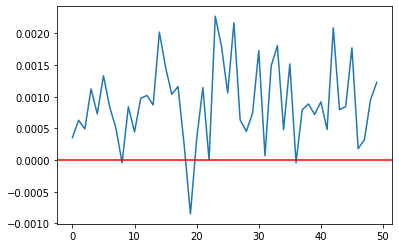

In [144]:
#plt.plot(samples, error)
#plt.plot(jnp.arange(len(error)), error)
#plt.axhline(c='r')
#plt.xscale("log")

#from google.colab import files
#plt.savefig("50_tries_wob_k1_t2.png", dpi=500)
#files.download("50_tries_wob_k1_t2.png") 

# Graphing

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

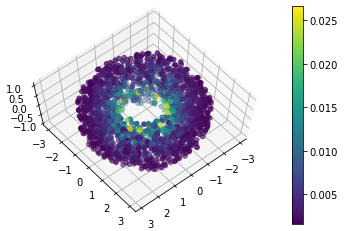

In [164]:
ax = plt.axes(projection='3d')
ax.view_init(70, 50)
p = ax.scatter3D(points[:,0], points[:,1], points[:,2], c=results)
plt.colorbar(p)

from google.colab import files
plt.savefig("wob_soln_torus_k1_t2.png", dpi=500)
files.download("wob_soln_torus_k1_t2.png") 